In [127]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import logging
from sklearn.preprocessing import MinMaxScaler

In [128]:
def read_csv(csvFilePath):
    return pd.read_csv(csvFilePath)

In [129]:
MAX_EPOCHS = 30
# wstępne ustawienia wykresów
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 8
json_file_path = "config.json"  # ścieżka do pliku konfiguracyjnego

with open(json_file_path) as json_file:
    config = json.load(json_file)

In [130]:
#wersje bibliotek
print("Tensorflow version: " + tf.__version__)
print("Keras version: " + tf.keras.__version__)
print("Pandas version: " + pd.__version__)

#sprawdzenie czy model istnieje
if os.path.exists(config['modelPath']):
    train_new_model = False
else:
    train_new_model = True

Tensorflow version: 2.9.1
Keras version: 2.9.0
Pandas version: 1.4.3


In [131]:
train_df = read_csv("weather.csv")
train_df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


In [132]:
filterArray = ["Date Time", "p (mbar)", "T (degC)", "rh (%)"]
train_df = train_df.filter(items=filterArray)

# sprawdzenie poprawności filtrowania:
if train_df.shape[1] == len(filterArray):
    logging.info("Odfiltrowywanie zakończone sukcesem!")
else:
    raise Exception('Sprawdz, czy nie ma literowek w filtrach <filterArray>')
train_df.describe()

,p (mbar),T (degC),rh (%)
count,420551.000000,420551.000000,420551.000000
mean,989.212776,9.450147,76.008259
std,8.358481,8.423365,16.476175
min,913.600000,-23.010000,12.950000
25%,984.200000,3.360000,65.210000
50%,989.580000,9.420000,79.300000
75%,994.720000,15.470000,89.400000
max,1015.350000,37.280000,100.000000


In [133]:
train_df.describe()

,p (mbar),T (degC),rh (%)
count,420551.000000,420551.000000,420551.000000
mean,989.212776,9.450147,76.008259
std,8.358481,8.423365,16.476175
min,913.600000,-23.010000,12.950000
25%,984.200000,3.360000,65.210000
50%,989.580000,9.420000,79.300000
75%,994.720000,15.470000,89.400000
max,1015.350000,37.280000,100.000000


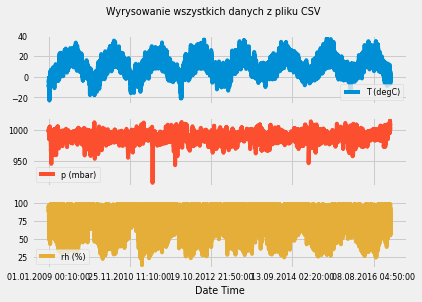

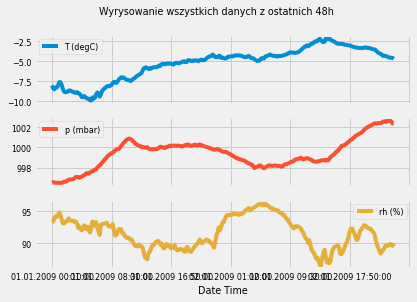

In [134]:
def show_tpr_graphs(dataFrame):
    try:
        logging.info("Przygotowywanie wykresów...")
        plot_cols = ['T (degC)', 'p (mbar)', 'rh (%)']
        plot_features = dataFrame[plot_cols]
        plot_features.index = dataFrame['Date Time']
        _ = plot_features.plot(subplots=True, title="Wyrysowanie wszystkich danych z pliku CSV")
        # wyrysowanie wykresu dla ostatnich 288 (48h) przypadków - dane są pobierane co 10 minut
        plot_features = dataFrame[plot_cols][:288]
        plot_features.index = dataFrame['Date Time'][:288]
        _ = plot_features.plot(subplots=True, title="Wyrysowanie wszystkich danych z ostatnich 48h")
        plt.show()
        logging.info("Wykresy wygenerowane poprawnie!")
    except Exception as e:
        print(f"Pojawił się błąd podczas rysowania wykresów danych treningowych. Powód: {e}")

show_tpr_graphs(train_df)

In [135]:
#sieć neuronowa będzie trenowana na podstawie danych z czasu oraz temperatury
filterArray = ['Date Time', 'T (degC)']
data_to_train_network = train_df.filter(items=filterArray)
#lepsze wyniki będę osiągnięte gdy dokonana zostanie konwersja typu DateTime na timestamp
data_to_train_network['Date Time'] = pd.to_datetime(train_df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S').map(pd.Timestamp.timestamp)
data_to_train_network

,Date Time,T (degC)
0,1.230769e+09,-8.02
1,1.230769e+09,-8.41
2,1.230770e+09,-8.51
3,1.230770e+09,-8.31
4,1.230771e+09,-8.27
...,...,...
420546,1.483226e+09,-4.05
420547,1.483227e+09,-3.35
420548,1.483228e+09,-3.16
420549,1.483228e+09,-4.23


In [136]:
# Normalizacja danych
scaler = MinMaxScaler(feature_range=(0, 1))
data_to_train_network = scaler.fit_transform(data_to_train_network)

In [137]:
n = len(data_to_train_network)
train_x, train_y = data_to_train_network[:,1][0:int(n*.7)], data_to_train_network[:,0][0:int(n*.7)]
val_x, val_y = data_to_train_network[:,1][int(n * .7):int(n * .9)], data_to_train_network[:,0][int(n * .7):int(n * .9)]
test_x, test_y = data_to_train_network[:,1][int(n*.9):], data_to_train_network[:,0][int(n*.9):]

In [144]:
train_tup = (np.array(train_x), np.array(train_y))
val_tup = (np.array(val_x), np.array(val_y))
test_tup = (np.array(test_x), np.array(test_y))

print("Min: ", np.min(train_tup[0]))
print("Max: ", np.max(train_tup[0]))
print(train_tup[0].shape[0])
print(train_tup[1].shape[0])

Min:  0.0
Max:  0.9764471720019903
294385
294385


array([0.24863161, 0.24216288, 0.24050423, ..., 0.62016918, 0.6214961 ,
       0.61917399])

In [145]:
#utworzenie modelu ML
if train_new_model:
    k = 2 # mnożnik liczby neuronów w warstwach ukrytych
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=1),
        tf.keras.layers.Dense(64*k, activation=tf.nn.relu),
        tf.keras.layers.Dense(64*k, activation=tf.nn.relu),
        tf.keras.layers.Dense(60, activation=tf.nn.softmax)
    ])

    #kompilacja modelu
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(train_tup[0], train_tup[1], epochs=MAX_EPOCHS)
    test_loss, test_acc = model.evaluate(test_tup[0], test_tup[1])
    print(f"Dokładność: {test_acc}")

    #zapisanie modelu
    model.save(config['modelPath'])
else:
    model = tf.keras.models.load_model(config['modelPath'])

Epoch 1/30
9200/9200 [==============================] - 8s 790us/step - loss: 0.0177 - accuracy: 3.3969e-06
Epoch 2/30
9200/9200 [==============================] - 7s 789us/step - loss: 4.3033e-09 - accuracy: 3.3969e-06
Epoch 3/30
9200/9200 [==============================] - 7s 793us/step - loss: 1.6441e-10 - accuracy: 3.3969e-06
Epoch 4/30
9200/9200 [==============================] - 7s 809us/step - loss: 6.4791e-12 - accuracy: 3.3969e-06
Epoch 5/30
9200/9200 [==============================] - 7s 805us/step - loss: 0.0000e+00 - accuracy: 3.3969e-06
Epoch 6/30
9200/9200 [==============================] - 7s 794us/step - loss: 0.0000e+00 - accuracy: 3.3969e-06
Epoch 7/30
9200/9200 [==============================] - 9s 937us/step - loss: 0.0000e+00 - accuracy: 3.3969e-06
Epoch 8/30
9200/9200 [==============================] - 8s 825us/step - loss: 0.0000e+00 - accuracy: 3.3969e-06
Epoch 9/30
9200/9200 [==============================] - 7s 780us/step - loss: 0.0000e+00 - accuracy: 3.3969e

INFO:tensorflow:Assets written to: weather.model\assets


In [147]:
predictions = model.predict(train_tup[0])
 # uzyskiwanie RMSE - Root Mean Square Error (jest standardowym sposobem pomiaru błędu modelu w przewidywaniu danych ilościowych)
RMSE = np.sqrt(np.mean(predictions - test_tup[1]) ** 2)
print(f"Współczynnik RMSE wynosi: {RMSE}")

9200/9200 [==============================] - 5s 542us/step


ValueError: operands could not be broadcast together with shapes (294385,60) (42056,) 